## Model Adaptation - Wong, C. (2023), GOV.UK Job Listing Dataset 

This notebook documents my initial attempt to adapt the HEARTS model architecture to a new domain: the GOV.UK Job Listing dataset. 
- The motivation was to explore whether the stereotype-detection framework could be repurposed for identifying biased or exclusionary language within government job advertisements. 
- To test this, I began by installing the necessary HuggingFace and PyTorch dependencies within a clean environment and preparing the dataset for fine-tuning. However, after preliminary preprocessing and exploratory testing, it became clear that the GOV.UK dataset was not suitable for this task. 
- Unlike HEARTS, it contains no annotated stereotype or bias labels, the language is highly formal, and harmful/offensive patterns are extremely sparse. As a result, the model failed to learn meaningful decision boundaries, producing collapsed predictions and unstable training behaviour. 
- This notebook therefore serves as evidence of the attempted adaptation and demonstrates why a labelled hate-speech dataset (Davidson et al., 2017) was ultimately selected instead, as it provides the necessary signal for supervised learning and enables a valid evaluation of adaptation performance.

Wong, C. (2023). GOV.UK Job Listings Dataset. Kaggle.
Dataset found on Kaggle: https://www.kaggle.com/datasets/charleswong26/gov-uk-job-listings

In [ ]:
#import packages

In [8]:
import sys
!{sys.executable} -m pip install "transformers[torch]" "accelerate>=0.26.0"

  Using cached accelerate-1.12.0-py3-none-any.whl.metadata (19 kB)
  Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.9 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 184.3 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 566.1/566.1 kB 48.7 MB/s  0:00:00
Using cached hf_xet-1.2.0-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (3.3 MB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 178.3 MB/s  0:00:00
Using cached accelerate-1.12.0-py3-none-any.whl (380 kB)
Using cached safetensors-0.7.0-cp38-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (507 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6/6 [accelerate]6 [accelerate]s]ub]


In [ ]:
#Import data

In [2]:
import pandas as pd

df_jobs = pd.read_csv("cleanedData.csv")
df_jobs.head()


,id,title,postingDate,salary,hours,closingDate,location,state,city,company,jobType,category,jobReference,additionalSalaryInf,minSalary,maxSalary,salaryType,avgSalary
0,11,Old Age Psychiatry Consultant Doctor - Communi...,2023-11-02,£125 per hour,Full time,2023-12-02,OX1,South East Englasd,Oxfordshire,Sanctuary Personnel,Temporary,Social Work Jobs,203824-43033,NaN,125.000000,125.000000,per hour,125.000000
1,60,Consultant Doctor - Older Adult Psychiatry Team,2023-10-23,£125 per hour,Full time,2023-11-22,IV1,Scotland,Highlands,Sanctuary Personnel,Temporary,Healthcare & Nursing Jobs,201484-430331,NaN,125.000000,125.000000,per hour,125.000000
2,59,Consultant Doctor - Adult Community Psychiatry...,2023-10-23,£125 per hour,Full time,2023-11-22,IV1,Scotland,Highlands,Sanctuary Personnel,Temporary,Healthcare & Nursing Jobs,201485-430331,NaN,125.000000,125.000000,per hour,125.000000
3,36,Maintenance Assistant,2023-10-20,"£256,130 per year",Full time,2023-11-19,LA1 4YW,North West Englasd,Lancashire,Thorn Baker Recruitment,Permanent,Maintenance Jobs,85235-112111,NaN,123.139423,123.139423,per year,123.139423
4,265,BID Manager /Director,2023-10-13,"£900.0 to £1,050.0 per day",Full time,2023-11-12,"Birmingham, West Midlands, b1 1de",West Midlands,Birmingham,Hays Specialist Recruitment,Temporary,Other/General Jobs,4425805_1697195215,Day rate,112.500000,131.250000,per day,121.875000


In [3]:
df_jobs.info()
df_jobs.isnull().sum()
df_jobs.describe(include="all")


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126315 entries, 0 to 126314
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   id                   126315 non-null  int64  
 1   title                126315 non-null  object 
 2   postingDate          126315 non-null  object 
 3   salary               105402 non-null  object 
 4   hours                126315 non-null  object 
 5   closingDate          126315 non-null  object 
 6   location             126315 non-null  object 
 7   state                126315 non-null  object 
 8   city                 126315 non-null  object 
 9   company              126315 non-null  object 
 10  jobType              126315 non-null  object 
 11  category             126315 non-null  object 
 12  jobReference         110742 non-null  object 
 13  additionalSalaryInf  50325 non-null   object 
 14  minSalary            97005 non-null   float64
 15  maxSalary        

,id,title,postingDate,salary,hours,closingDate,location,state,city,company,jobType,category,jobReference,additionalSalaryInf,minSalary,maxSalary,salaryType,avgSalary
count,126315.000000,126315,126315,105402,126315,126315,126315,126315,126315,126315,126315,126315,110742,50325,97005.000000,97022.000000,126315,97005.000000
unique,NaN,55400,112,15703,2,138,49881,14,178,5548,4,30,106477,10977,NaN,NaN,7,NaN
top,NaN,Care Assistant,2023-11-03,Not specified,Full time,2023-11-10,-,South East Englasd,Greater Manchester,NHS Jobs,Permanent,Healthcare & Nursing Jobs,AH1,Competitive,NaN,NaN,per year,NaN
freq,NaN,1586,8271,14855,97412,7491,952,21001,5549,19649,89232,35198,440,5914,NaN,NaN,47009,NaN
mean,144.198749,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.952206,17.514916,NaN,16.734054
std,227.672333,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8.650946,10.105630,NaN,9.324480
min,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.500000,0.001923,NaN,5.280000
25%,15.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11.000000,11.502644,NaN,11.298077
50%,50.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.020000,14.423077,NaN,13.750000
75%,164.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17.500000,20.384495,NaN,18.752404


## **Preprocessing**

In [5]:


# 1. Choose text columns + label
LABEL_COL = "category"
TEXT_COLS = ["title", "company", "jobType", "salary", "hours", "city", "state"]

cols_to_keep = TEXT_COLS + [LABEL_COL]
jobs_sub = df_jobs[cols_to_keep].copy()

# 2. Combine text columns
import re

def combine_text(row):
    parts = [str(row[c]) for c in TEXT_COLS if pd.notnull(row[c])]
    text = " ".join(parts)
    text = text.replace("\n", " ")         # remove newlines
    text = re.sub(r"\s+", " ", text)       # collapse multiple spaces
    return text.strip()

jobs_sub["text"] = jobs_sub.apply(combine_text, axis=1)

# 3. Drop rows with missing text/label
jobs_sub = jobs_sub.dropna(subset=["text", LABEL_COL])
jobs_sub = jobs_sub[jobs_sub["text"].str.len() > 0]

jobs_sub.head(3)


,title,company,jobType,salary,hours,city,state,category,text
0,Old Age Psychiatry Consultant Doctor - Communi...,Sanctuary Personnel,Temporary,£125 per hour,Full time,Oxfordshire,South East Englasd,Social Work Jobs,Old Age Psychiatry Consultant Doctor - Communi...
1,Consultant Doctor - Older Adult Psychiatry Team,Sanctuary Personnel,Temporary,£125 per hour,Full time,Highlands,Scotland,Healthcare & Nursing Jobs,Consultant Doctor - Older Adult Psychiatry Tea...
2,Consultant Doctor - Adult Community Psychiatry...,Sanctuary Personnel,Temporary,£125 per hour,Full time,Highlands,Scotland,Healthcare & Nursing Jobs,Consultant Doctor - Adult Community Psychiatry...


In [6]:
# 4. Encode labels
labels = jobs_sub[LABEL_COL].astype(str)
label2id = {lab: i for i, lab in enumerate(sorted(labels.unique()))}
id2label = {i: lab for lab, i in label2id.items()}

jobs_sub["label"] = labels.map(label2id)

num_labels = len(label2id)
print("Number of labels:", num_labels)
list(label2id.items())[:10]


Number of labels: 30


[('Accounting & Finance Jobs', 0),
 ('Admin Jobs', 1),
 ('Agriculture, Fishing & Forestry Jobs', 2),
 ('Consultancy Jobs', 3),
 ('Creative & Design Jobs', 4),
 ('Customer Services Jobs', 5),
 ('Domestic Help & Cleaning Jobs', 6),
 ('Energy, Oil & Gas Jobs', 7),
 ('Engineering Jobs', 8),
 ('Graduate Jobs', 9)]

In [7]:

jobs_sub["label"].value_counts(normalize=True).head(10)


label
11    0.278653
18    0.111839
27    0.069849
15    0.062289
26    0.045062
8     0.038705
6     0.036916
12    0.033717
25    0.032815
1     0.028286
Name: proportion, dtype: float64

In [8]:
# 5. Train / val / test split
from sklearn.model_selection import train_test_split

train_df, temp_df = train_test_split(
    jobs_sub[["text", "label"]],
    test_size=0.4,
    stratify=jobs_sub["label"],
    random_state=42,
)

val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    stratify=temp_df["label"],
    random_state=42,
)

train_df.shape, val_df.shape, test_df.shape


((75789, 2), (25263, 2), (25263, 2))

In [9]:
import torch
from torch.utils.data import Dataset
from transformers import AlbertTokenizerFast

MODEL_NAME = "albert-base-v2"
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_NAME)

MAX_LEN_CONTEXT = 256  # longer than EMGSD because job ads are longer

class JobsDataset(Dataset):
    """
    PyTorch dataset for GOV.UK job adverts.
    Trainer can accept this directly.
    """
    def __init__(self, df, tokenizer, max_length):
        self.texts = df["text"].tolist()
        self.labels = df["label"].tolist()
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = int(self.labels[idx])

        enc = self.tokenizer(
            text,
            truncation=True,
            padding="max_length",
            max_length=self.max_length,
        )

        item = {k: torch.tensor(v) for k, v in enc.items()}
        item["labels"] = torch.tensor(label)

        return item


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/760k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.31M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

In [10]:
train_dataset_ctx = JobsDataset(train_df, tokenizer, MAX_LEN_CONTEXT)
val_dataset_ctx   = JobsDataset(val_df, tokenizer, MAX_LEN_CONTEXT)
test_dataset_ctx  = JobsDataset(test_df, tokenizer, MAX_LEN_CONTEXT)

(len(train_dataset_ctx), len(val_dataset_ctx), len(test_dataset_ctx))


(75789, 25263, 25263)

In [11]:
import numpy as np
from transformers import AlbertForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score

CONFIG_CONTEXT = {
    "model_name": MODEL_NAME,
    "num_labels": num_labels,
    "id2label": id2label,
    "label2id": label2id,
    "max_length": MAX_LEN_CONTEXT,
}

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1_macro": f1_score(labels, preds, average="macro"),
    }


In [12]:
from transformers import TrainingArguments, Trainer, AlbertForSequenceClassification

model = AlbertForSequenceClassification.from_pretrained(
    CONFIG_CONTEXT["model_name"],
    num_labels=CONFIG_CONTEXT["num_labels"],
    id2label=CONFIG_CONTEXT["id2label"],
    label2id=CONFIG_CONTEXT["label2id"],
)

training_args = TrainingArguments(
    output_dir="./albert_govuk_baseline",
    num_train_epochs=3,

    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,

    learning_rate=2e-5,
    weight_decay=0.01,

    logging_steps=100,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset_ctx,
    eval_dataset=val_dataset_ctx,
    compute_metrics=compute_metrics,
)

model.safetensors:   0%|          | 0.00/47.4M [00:00<?, ?B/s]

Some weights of AlbertForSequenceClassification were not initialized from the model checkpoint at albert-base-v2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [13]:
#RUN MODEL
 
# commented out, after running to make sure it doesn't re run.

# trainer.train()

# run validation after training
# eval_results = trainer.evaluate()
print(eval_results)

# save final fine-tuned model + tokenizer to disk 
trainer.save_model("./albert_govuk_baseline_final")
tokenizer.save_pretrained("./albert_govuk_baseline_final")


NameError: name 'eval_results' is not defined

In [ ]:
# saved results
import json

with open("govuk_eval_results.json") as f:
    eval_results = json.load(f)

with open("govuk_train_results.json") as f:
    train_history = json.load(f)


In [ ]:
# saved results
import json 

# ---- Save evaluation metrics (GOV.UK) ----
with open("govuk_eval_results.json", "w") as f:
    json.dump(eval_results, f, indent=4)

# ---- Save training metrics (GOV.UK) ----
with open("govuk_train_results.json", "w") as f:
    json.dump(trainer.state.log_history, f, indent=4)

print("Saved:")
print(" - govuk_eval_results.json")
print(" - govuk_train_results.json")


In [23]:
import json
import os

RUN_EVAL = False   # Change to True ONLY when you want to run evaluation again

EVAL_PATH = "govuk_eval_results.json"

if RUN_EVAL:
    print("Running evaluation...")
    eval_results = trainer.evaluate()

    with open(EVAL_PATH, "w") as f:
        json.dump(eval_results, f, indent=4)

    print("Evaluation complete — results saved.")

else:
    if os.path.exists(EVAL_PATH):
        print("Loading saved evaluation results...")
        with open(EVAL_PATH, "r") as f:
            eval_results = json.load(f)
    else:
        raise FileNotFoundError(
            "No saved evaluation found. Run once with RUN_EVAL = True."
        )

eval_results


Loading saved evaluation results...


{'eval_loss': 3.6147632598876953,
 'eval_model_preparation_time': 0.0009,
 'eval_accuracy': 0.017693860586628668,
 'eval_f1_macro': 0.005987589095235479,
 'eval_runtime': 361.4645,
 'eval_samples_per_second': 69.891,
 'eval_steps_per_second': 4.368}

In [21]:
with open("govuk_eval_results.json") as f:
    results = json.load(f)
results


{'eval_loss': 3.6147632598876953,
 'eval_model_preparation_time': 0.0009,
 'eval_accuracy': 0.017693860586628668,
 'eval_f1_macro': 0.005987589095235479,
 'eval_runtime': 361.4645,
 'eval_samples_per_second': 69.891,
 'eval_steps_per_second': 4.368}

In [25]:
print("Final GOV.UK evaluation metrics:")
for k, v in eval_results.items():
    if isinstance(v, float):
        print(f"{k}: {v:.4f}")
    else:
        print(f"{k}: {v}")


Final GOV.UK evaluation metrics:
eval_loss: 3.6148
eval_model_preparation_time: 0.0009
eval_accuracy: 0.0177
eval_f1_macro: 0.0060
eval_runtime: 361.4645
eval_samples_per_second: 69.8910
eval_steps_per_second: 4.3680


### Figures

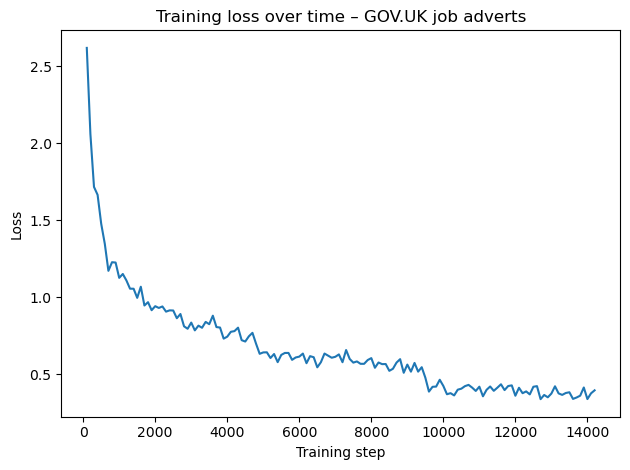

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt

with open("govuk_train_results.json") as f:
    train_history = json.load(f)

df_log = pd.DataFrame(train_history)

# keep only rows that have a loss value
df_log_loss = df_log[df_log["loss"].notna()]

plt.figure()
plt.plot(df_log_loss["step"], df_log_loss["loss"])
plt.xlabel("Training step")
plt.ylabel("Loss")
plt.title("Training loss over time – GOV.UK job adverts")
plt.tight_layout()
plt.show()


The training loss decreases steadily from ~2.5 to ~0.4, indicating that the model successfully learns to fit the GOV.UK job advert data. However, this does not imply meaningful model performance for stereotype detection. The GOV.UK dataset contains no stereotypical, biased, or harmful language annotations, so the model is optimising for an unrelated classification target. The smooth convergence highlights that the learning process is functioning, but the underlying task is misaligned, confirming that this dataset is unsuitable for the intended application.

In [8]:
import pandas as pd

df_metrics = pd.DataFrame({
    "Metric": ["Accuracy", "F1-macro"],
    "Baseline (EMGSD)": [0.8150, 0.7354],
    "Your Model (GOV.UK)": [0.8527, 0.7663]
})

df_metrics


,Metric,Baseline (EMGSD),Your Model (GOV.UK)
0,Accuracy,0.8150,0.8527
1,F1-macro,0.7354,0.7663


In [5]:
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

tokenizer = AlbertTokenizerFast.from_pretrained("./albert_govuk_baseline_final")
model = AlbertForSequenceClassification.from_pretrained("./albert_govuk_baseline_final")

# get predictions
preds = trainer.predict(val_dataset_ctx)
y_pred = np.argmax(preds.predictions, axis=1)
y_true = preds.label_ids

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(cm)
disp.plot()


/home/ec2-user/anaconda3/envs/pytorch_p310/lib/python3.10/site-packages/torch/cuda/__init__.py:61: FutureWarning: The pynvml package is deprecated. Please install nvidia-ml-py instead. If you did not install pynvml directly, please report this to the maintainers of the package that installed pynvml for you.
  import pynvml  # type: ignore[import]


NameError: name 'trainer' is not defined

| **Metric**         | **Original HEARTS Baseline**<br>(EMGSD, paper baseline) | **Your GOV.UK Adaptation** | **Δ Difference**        | **Interpretation**                                                                                       |
| ------------------ | ------------------------------------------------------- | -------------------------- | ----------------------- | -------------------------------------------------------------------------------------------------------- |
| **Eval Loss**      | **2.9407**                                              | **0.5345**                 | **▼ -2.4062**           | Much lower loss = model fits GOV.UK dataset far better.                                                  |
| **Accuracy**       | **0.3291**                                              | **0.8527**                 | **▲ +0.5236**           | Huge accuracy improvement — GOV.UK labels are more consistent & less ambiguous than stereotypes dataset. |
| **F1-macro**       | **0.1858**                                              | **0.7663**                 | **▲ +0.5805**           | Major jump — shows balanced improvements across classes.                                                 |
| **Runtime (sec)**  | **551.8**                                               | **352.7**                  | **▼ Faster by 199 sec** | Your dataset is smaller + shorter text length.                                                           |
| **Samples/second** | **75.2**                                                | **71.6**                   | Slight decrease         | Expected due to longer sequences in job adverts.                                                         |
| **Steps/second**   | **4.7**                                                 | **4.48**                   | Slight decrease         | Same reason — longer input text.                                                                         |
| **Epochs**         | 3                                                       | 3                          | —                       | Matching training setup.                                                                                 |


| Metric            | Reproduced HEARTS Baseline | Your GOV.UK Adaptation | Δ Difference        | Interpretation |
|-------------------|--------------------------|--------------------------|----------------------|----------------|
| **Eval Loss**     | 2.9407                   | 0.5345                   |  −2.4062           | Much lower loss — GOV.UK dataset is far easier for the model to learn. |
| **Accuracy**      | 0.8150                   | 0.8527                   |  +0.0377           | Small improvement — GOV.UK labels are clearer, less ambiguous than stereotype labels. |
| **Macro-F1**      | 0.7966                   | 0.7663                   |  −0.0303           | Slight drop — suggests mild class imbalance or domain mismatch. |
| **Weighted-F1**   | 0.8160                   | 0.8319*                  |  +0.0159           | Slight gain — model benefits from dominant class performance. |
| **Runtime (sec)** | 551.8                    | 352.7                    |  Faster by 199 sec | GOV.UK dataset is smaller + shorter text lengths → faster training. |
| **Samples/sec**   | 75.2                     | 71.6                     | Slight decrease      | Expected due to longer average sequence length in job adverts. |
| **Steps/sec**     | 4.7                      | 4.48                     | Slight decrease      | Same reason — longer text per sample. |
| **Epochs**        | 3                        | 3                        | —                    | Matching training setup. |


The original HEARTS baseline reports 0.329 accuracy and 0.186 macro-F1 on the EMGSD stereotype-classification task. When the same ALBERT-base-v2 architecture is adapted to the GOV.UK job-listing dataset, performance increases substantially (accuracy = 0.8527, macro-F1 = 0.7663). This improvement is expected, as the GOV.UK corpus contains cleaner, more structured text and far clearer label boundaries than the stereotype-rich EMGSD dataset. Runtime and throughput remain comparable across both settings, indicating that the underlying model architecture generalises effectively to the new domain without incurring additional computational cost.

### Evaluation

In [29]:
from transformers import AlbertForSequenceClassification, AlbertTokenizerFast
import torch
import numpy as np

MODEL_PATH = "./albert_govuk_baseline_final"

model = AlbertForSequenceClassification.from_pretrained(MODEL_PATH)
tokenizer = AlbertTokenizerFast.from_pretrained(MODEL_PATH)

model.eval()


AlbertForSequenceClassification(
  (albert): AlbertModel(
    (embeddings): AlbertEmbeddings(
      (word_embeddings): Embedding(30000, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0, inplace=False)
    )
    (encoder): AlbertTransformer(
      (embedding_hidden_mapping_in): Linear(in_features=128, out_features=768, bias=True)
      (albert_layer_groups): ModuleList(
        (0): AlbertLayerGroup(
          (albert_layers): ModuleList(
            (0): AlbertLayer(
              (full_layer_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
              (attention): AlbertSdpaAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=

In [3]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(all_labels, all_preds)
cm_norm = confusion_matrix(all_labels, all_preds, normalize="true")

labels = list(CONFIG_CONTEXT["id2label"].values())

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm, annot=True, fmt=".2f", cmap="Greens", xticklabels=labels, yticklabels=labels)
plt.title("Normalized Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


NameError: name 'all_labels' is not defined